## Task
Finish training and validate on test data (print confusion matrix and report)

In [1]:
import os

import tqdm
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

## Fish Dataset

You can download the dataset from here: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset?select=NA_Fish_Dataset

In [2]:
directory = 'NA_Fish_Dataset'

In [3]:
labels = os.listdir(directory)

In [4]:
labels

['Sea Bass',
 'Red Mullet',
 'Gilt Head Bream',
 'Red Sea Bream',
 'Shrimp',
 'Black Sea Sprat',
 'Horse Mackerel',
 'Striped Red Mullet',
 'Trout']

In [5]:
image_paths = []
target = []
for fish_type in labels:
    for file in os.listdir(os.path.join(directory, fish_type)):
        image_paths.append(os.path.join(directory, fish_type, file))
        target.append(fish_type)

In [6]:
df = pd.DataFrame({'img' : image_paths, 'target' : target})
df.head()

,img,target
0,NA_Fish_Dataset/Sea Bass/48.JPG,Sea Bass
1,NA_Fish_Dataset/Sea Bass/49.JPG,Sea Bass
2,NA_Fish_Dataset/Sea Bass/8.JPG,Sea Bass
3,NA_Fish_Dataset/Sea Bass/9.JPG,Sea Bass
4,NA_Fish_Dataset/Sea Bass/14.JPG,Sea Bass


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     430 non-null    object
 1   target  430 non-null    object
dtypes: object(2)
memory usage: 6.8+ KB


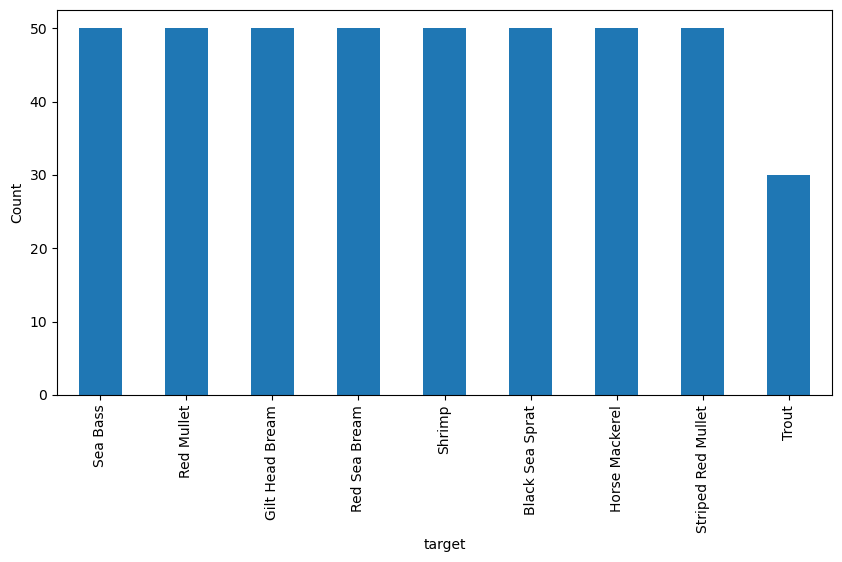

In [8]:
plt.figure(figsize=(10, 5))
df['target'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.show()

## Preprocessing

In [9]:
def image_encoder(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Unable to load image at path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image

In [10]:
def binary_encoder(fish_type: str, all_unique_labels: list[str]) -> np.ndarray:
    return np.array([1 if fish_type == label else 0 for label in all_unique_labels])

In [11]:
df['img_encoded'] = df['img'].apply(image_encoder)
df['target_encoded'] = df['target'].apply(lambda x: binary_encoder(x, labels))

In [12]:
df

,img,target,img_encoded,target_encoded
0,NA_Fish_Dataset/Sea Bass/48.JPG,Sea Bass,"[[[73, 88, 111], [70, 86, 107], [78, 90, 106],...","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,NA_Fish_Dataset/Sea Bass/49.JPG,Sea Bass,"[[[49, 96, 145], [42, 90, 139], [46, 93, 143],...","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,NA_Fish_Dataset/Sea Bass/8.JPG,Sea Bass,"[[[19, 37, 61], [2, 35, 60], [14, 40, 62], [16...","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,NA_Fish_Dataset/Sea Bass/9.JPG,Sea Bass,"[[[4, 29, 60], [3, 36, 61], [4, 35, 65], [4, 3...","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,NA_Fish_Dataset/Sea Bass/14.JPG,Sea Bass,"[[[81, 102, 116], [72, 105, 115], [89, 108, 12...","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
425,NA_Fish_Dataset/Trout/00029.png,Trout,"[[[65, 110, 143], [72, 112, 147], [61, 110, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 1]"
426,NA_Fish_Dataset/Trout/00015.png,Trout,"[[[16, 14, 19], [14, 12, 15], [16, 14, 17], [1...","[0, 0, 0, 0, 0, 0, 0, 0, 1]"
427,NA_Fish_Dataset/Trout/00001.png,Trout,"[[[8, 15, 30], [6, 16, 28], [4, 16, 26], [5, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 1]"
428,NA_Fish_Dataset/Trout/00014.png,Trout,"[[[41, 89, 119], [43, 86, 120], [46, 91, 122],...","[0, 0, 0, 0, 0, 0, 0, 0, 1]"


## Split the data into train and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['img_encoded'].to_numpy(), df['target_encoded'].to_numpy(), test_size=0.2, random_state=10
)

## Dataset/Dataloader

In [14]:
class FishDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [15]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = FishDataset(X_train, y_train, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=4)

test_dataset = FishDataset(X_test, y_test, transform=transform)
testloader = DataLoader(test_dataset, batch_size=4)

In [16]:
X_train[0].shape

(224, 224, 3)

## Conv Model

Size of the output:
$$M_{new}=\dfrac{M-K}{stride}+1$$

Convolution 1:

$$M_{conv1}=224-5+1$$
$$M_{conv1}=220$$

Maxpooling 1:

$$M_{m1}=\dfrac{220-2}{2}+1$$
$$M_{m1}=110$$

Convolution 2:

$$M_{conv2}=110-5+1$$
$$M_{conv2}=106$$

Maxpooling 2:

$$M_{m2}=\dfrac{106-2}{2}+1$$
$$M_{m2}=53$$

In [17]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

        self.relu = nn.ReLU()

    def forward(self, x): # (3, 224, 224)
        x = self.pool(self.relu(self.conv1(x))) # (6, 110, 110)
        x = self.pool(self.relu(self.conv2(x))) # (16, 53, 53)

        x = x.view(-1, 16 * 53 * 53)  # !!! 44944
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**2 Channels -> 3 Channels**

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2mulit_input_output.png" width="750," align="center">


![CustomCNN.jpg](CustomCNN.jpg)

## Train the model

In [18]:
cuda = torch.cuda.is_available()

In [19]:
model = MyConvNet().cuda() if cuda else MyConvNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
train_losses = []
test_losses = []

for epoch in tqdm.tqdm(range(1,epochs+1)):
    train_loss = []
    test_loss = []
    for image, target in trainloader:
        image = image.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.float)
        optimizer.zero_grad()
        y_pred = model(image)
        loss = loss_fn(y_pred, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    with torch.no_grad():
        model.eval()
        for image, target in testloader:
            image = image.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float)
            y_pred = model(image)
            test_l = loss_fn(y_pred, target)
            test_loss.append(test_l.item())
    model.train()
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    tqdm.tqdm.write(f'epoch {epoch}: train_loss={np.mean(train_loss)}, test_loss={np.mean(test_loss)}')

  0%|          | 0/10 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:71: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
 10%|█         | 1/10 [00:04<00:42,  4.70s/it]

epoch 1: train_loss=2.200285609378371, test_loss=2.1897135214372114


 20%|██        | 2/10 [00:08<00:33,  4.18s/it]

epoch 2: train_loss=2.152730431667594, test_loss=2.0652554251930932


 30%|███       | 3/10 [00:12<00:28,  4.08s/it]

epoch 3: train_loss=1.8950881666915362, test_loss=1.5698794451626865


 40%|████      | 4/10 [00:16<00:24,  4.03s/it]

epoch 4: train_loss=1.511657207511192, test_loss=1.2928585355932063


 50%|█████     | 5/10 [00:20<00:19,  3.96s/it]

epoch 5: train_loss=1.2747637407724248, test_loss=1.1538060585206205


 60%|██████    | 6/10 [00:24<00:16,  4.03s/it]

epoch 6: train_loss=1.1067752668330835, test_loss=1.0625185282392935


 70%|███████   | 7/10 [00:28<00:12,  4.09s/it]

epoch 7: train_loss=0.9580774272597113, test_loss=0.9939237843182954


 80%|████████  | 8/10 [00:32<00:08,  4.16s/it]

epoch 8: train_loss=0.8204630020745965, test_loss=0.9309571256691759


 90%|█████████ | 9/10 [00:37<00:04,  4.17s/it]

epoch 9: train_loss=0.696790253180404, test_loss=0.8880115124312314


100%|██████████| 10/10 [00:41<00:00,  4.12s/it]

epoch 10: train_loss=0.5940791247195976, test_loss=0.8615254241634499


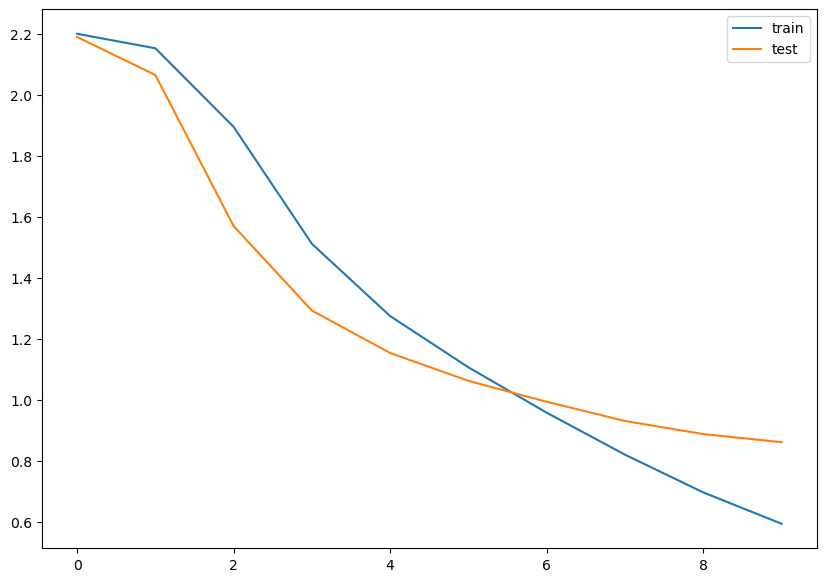

In [30]:
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

## Evaluate the model

In [31]:
cuda = torch.cuda.is_available()
num_correct = 0

predicted = []
ground_truth = []

model.eval()
with torch.no_grad():
    for image, target in testloader:
        image = image.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.float)

        y_pred = model(image)
        pred = torch.argmax(y_pred, dim=1)
        target = torch.argmax(target, dim=1)
        predicted.append(pred.detach().numpy())
        ground_truth.append(target.detach().numpy())
        correct_tensor = pred.eq(target)
        correct = np.squeeze(correct_tensor.cpu().numpy()) if cuda else np.squeeze(correct_tensor.numpy())
        num_correct += correct.sum()

test_acc = num_correct/len(testloader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test accuracy: 0.721


In [32]:
ground_truth, predicted = np.concatenate(ground_truth), np.concatenate(predicted)

In [44]:
labels

['Sea Bass',
 'Red Mullet',
 'Gilt Head Bream',
 'Red Sea Bream',
 'Shrimp',
 'Black Sea Sprat',
 'Horse Mackerel',
 'Striped Red Mullet',
 'Trout']

              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.69      0.82      0.75        11
           2       0.56      0.90      0.69        10
           3       0.86      0.60      0.71        10
           4       0.85      1.00      0.92        11
           5       0.75      0.92      0.83        13
           6       0.80      0.50      0.62         8
           7       0.50      0.33      0.40         6
           8       0.67      0.57      0.62         7

    accuracy                           0.72        86
   macro avg       0.72      0.68      0.68        86
weighted avg       0.74      0.72      0.71        86



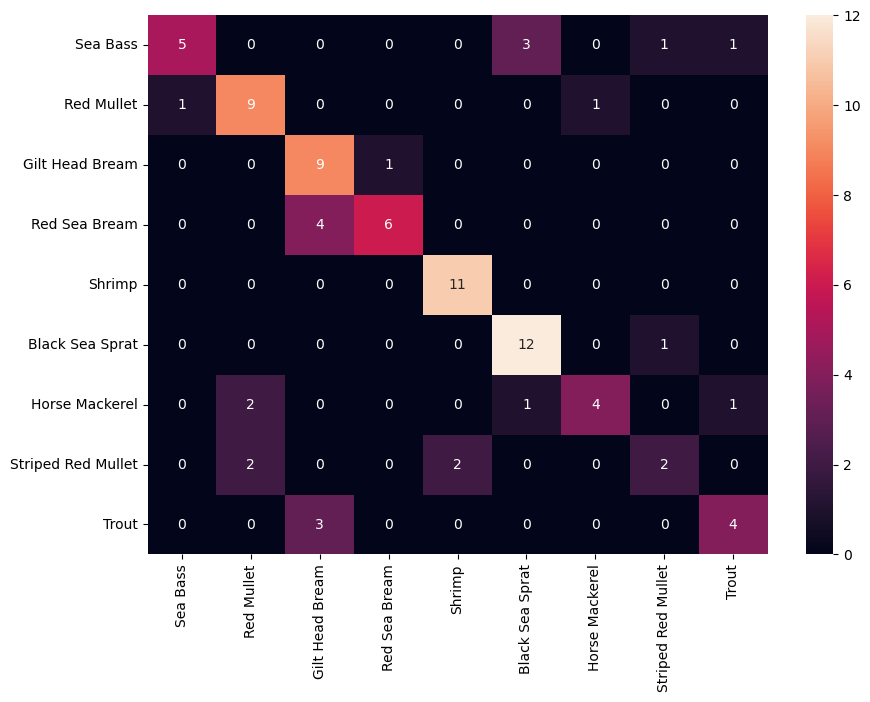

In [33]:
cm = confusion_matrix(ground_truth, predicted)
print(classification_report(ground_truth, predicted))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.show()

## Test

In [25]:
def image_encoder_test(url: str) -> np.ndarray:
    image = io.imread(url)
    plt.imshow(image)
    if image is None:
        raise FileNotFoundError(f"Unable to load image at path: {url}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image

In [26]:
def predict_fish(image_url: str, model: MyConvNet, labels: list[str], transform) -> str:
    model.eval()
    image = image_encoder_test(image_url)
    image = transform(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        y_pred = model(image)
        y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
        return labels[y_pred[0]]

In [27]:
labels

['Sea Bass',
 'Red Mullet',
 'Gilt Head Bream',
 'Red Sea Bream',
 'Shrimp',
 'Black Sea Sprat',
 'Horse Mackerel',
 'Striped Red Mullet',
 'Trout']

In [42]:
fish_path = directory + '/Red Mullet/00023.png'  

'Red Mullet'

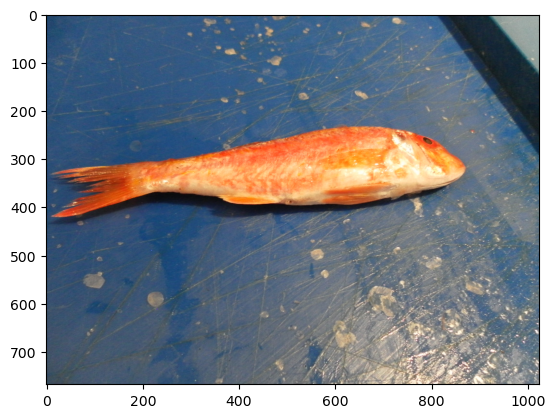

In [43]:
predict_fish(fish_path, model, labels, transform)